# A Tale of Two Time Scales
## Lan Zhang, Per A Mykland & Yacine Aït-Sahalia

### Abstract
It is a commonpractice in finance to estimate volatility from the sum of frequently sampled squared returns. However, market microstructure
poses challenges to this estimation approach, as evidenced by recent empirical studies in finance. The present work attempts to lay out
theoretical grounds that reconcile continuous-time modeling and discrete-time samples. We propose an estimation approach that takes
advantage of the rich sources in tick-by-tick data while preserving the continuous-time assumption on the underlying returns. Under our
framework, it becomes clear why and where the “usual” volatility estimator fails when the returns are sampled at the highest frequencies.
If the noise is asymptotically small, our work provides a way of finding the optimal sampling frequency. A better approach, the “two-scales
estimator,” works for any size of the noise.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from python_scripts.stochastic_models import generate_gbm, generate_heston
from python_scripts.volatility_estimators import rv_all, rv_sparse, tsrv

In [10]:
# Parameters
T = 1.0
mu = 0.0
sigma = 0.2
S0 = 1.0

eta = 0.003   # microstructure noise std on log-prices (set 0.0 to see no explosion)

steps_grid = np.array([50, 100, 200, 400, 800, 1600, 3200, 10000])
paths = 300
seed = 42

### Latent Price and Microstructure Noise

In high-frequency settings the *true* (or **latent**) price process is not directly observed.  
Let $S_t$ denote the latent efficient price process. At very high sampling frequencies, the observed transaction price is contaminated by market microstructure effects.

Following *Zhang, Mykland and Aït-Sahalia (2005)*, the observed **log-price** is modeled as:

$$
Y_{t_i} = \log S_{t_i} + \varepsilon_{t_i},
$$

where:
- $\log S_{t_i}$ is the latent log-price,
- $\varepsilon_{t_i}$ is an i.i.d. microstructure noise term with $\mathbb{E}[\varepsilon_{t_i}] = 0$ and $\mathbb{E}[\varepsilon_{t_i}^2] = \eta^2$.

The observed price is therefore:

$$
P^{\mathrm{obs}}_{t_i} = \exp(Y_{t_i}),
$$

which is the quantity available in tick-by-tick financial data.

This additive noise in log-prices induces an upward bias in the standard realized variance as the sampling frequency increases.  
The Two-Scales Realized Variance (TSRV) estimator is designed to remove this bias while retaining the information contained in high-frequency observations.



In [11]:
def add_noise(S, eta, seed):

    logS = np.log(S)
    rng = np.random.default_rng(seed)
    eps = rng.normal(loc=0.0, scale=eta, size=logS.shape)
    Y = logS + eps
    P_obs = np.exp(Y)

    return P_obs


In the presence of **market microstructure noise**, the integrated variance is estimated using the  
**Two-Scales Realized Variance (TSRV)** estimator.

---

The standard realized variance is upward biased.  
The **TSRV estimator** corrects this bias by combining:
- realized variance on the full grid,
- realized variances on sparse sub-grids.

Formally,
$$
\widehat{IV}^{TSRV}
=
\overline{RV}^{(K)} - \frac{\bar{n}}{n} RV^{(all)},
$$
where:
- $K \sim n^{2/3}$ is the subsampling frequency,
- $\overline{RV}^{(K)}$ is the average realized variance across sub-grids,
- $RV^{(all)}$ is the realized variance on the full grid.

This estimator is **consistent** for integrated variance in the presence of noise.

100%|██████████| 9999/9999 [00:00<00:00, 161000.45it/s]


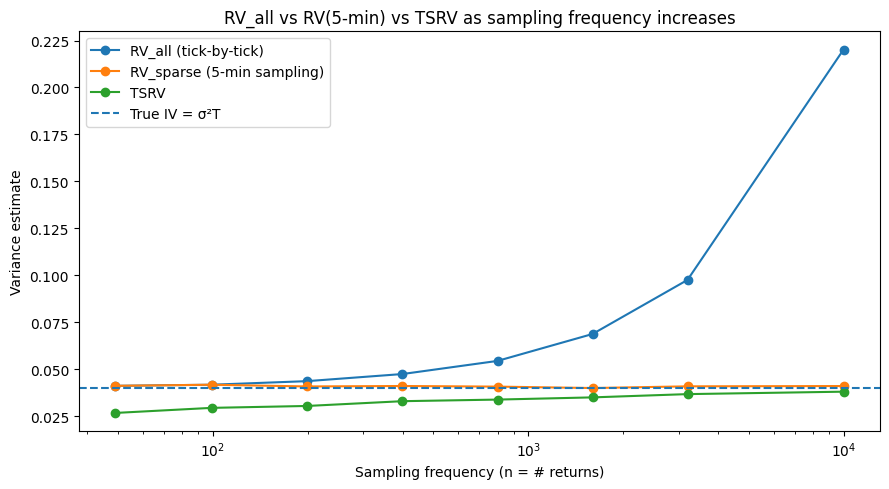

In [13]:
rv_all_mean, tsrv_mean, rv_5min_mean = [], [], []


for steps in steps_grid:

    rng = np.random.default_rng(seed)
    S = generate_gbm(steps=int(steps), T=T, paths=paths, mu=mu, sigma=sigma, S0=S0,seed=int(rng.integers(0, 1_000_000)))
    P_obs = add_noise(S=S, eta=eta, seed=seed)

    # Define a 5-minute-like sparse step:
    step_5min = max(1, int(np.floor((steps - 1) / 78)))     # assume steps corresponds to a "day", so take about 1/78 of samples

    rv_vals = np.array([rv_all(P_obs[:, j]) for j in range(paths)], dtype=float)
    tsrv_vals = np.array([tsrv(P_obs[:, j]) for j in range(paths)], dtype=float)
    rv5_vals = np.array([rv_sparse(P_obs[:, j], step=step_5min) for j in range(paths)], dtype=float)

    rv_all_mean.append(rv_vals.mean())
    tsrv_mean.append(tsrv_vals.mean())
    rv_5min_mean.append(rv5_vals.mean())

# Take the mean of all paths' estimators
rv_all_mean = np.array(rv_all_mean)
tsrv_mean = np.array(tsrv_mean)
rv_5min_mean = np.array(rv_5min_mean)
iv_true = sigma**2 * T


# Plot
plt.figure(figsize=(9, 5))
plt.plot(steps_grid - 1, rv_all_mean, marker="o", label="RV_all (tick-by-tick)")
plt.plot(steps_grid - 1, rv_5min_mean, marker="o", label="RV_sparse (5-min sampling)")
plt.plot(steps_grid - 1, tsrv_mean, marker="o", label="TSRV")
plt.axhline(iv_true, linestyle="--", label="True IV = σ²T")

plt.xscale("log")
plt.xlabel("Sampling frequency (n = # returns)")
plt.ylabel("Variance estimate")
plt.title("RV_all vs RV(5-min) vs TSRV as sampling frequency increases")
plt.legend()
plt.tight_layout()
plt.show()